In [3]:
import torch

import torchvision

from torchvision import datasets, transforms


In [ ]:
pip install --upgrade torch


In [4]:
import torch
print(torch.__version__)


2.4.0


In [ ]:
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [5]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [6]:
#from google.colab import drive

from PIL import Image

import os

In [ ]:
#drive.mount('/content/drive')

In [7]:
dataset_path = '/kaggle/input/tumor-trace-data'


In [8]:
from torch.utils.data import Dataset

**loading custom dataset**

In [9]:
class BreastCancerDataset(Dataset):

    def __init__(self, dataset_path, transform=None):

        self.dataset_path = dataset_path

        self.transform = transform

        self.samples = self._load_samples()



        # Debug: Print the number of samples loaded

        print(f"Number of samples found: {len(self.samples)}")

        if len(self.samples) == 0:

            raise ValueError(f"No valid samples found in {self.dataset_path}")



    def _load_samples(self):

        # List all image files in the directory structure and assign labels

        samples = []

        for label in ['Benign', 'Malignant']:

            label_dir = os.path.join(self.dataset_path, label)

            if not os.path.exists(label_dir):

                continue

            for root, _, files in os.walk(label_dir):

                for file in files:

                    if file.lower().endswith(('.jpg', '.png', '.jpeg')):

                        file_path = os.path.join(root, file)

                        samples.append((file_path, 0 if label == 'Benign' else 1))  # 0 for Benign, 1 for Malignant

        return samples



    def __len__(self):

        return len(self.samples)



    def __getitem__(self, idx):

        image_path, label = self.samples[idx]

        image = Image.open(image_path).convert('RGB')  # Load the image

        if self.transform:

            image = self.transform(image)

        return image, label




In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define the transform

transform = transforms.Compose([

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

])



# Create the dataset and dataloader for each split (train, test, val)

train_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-dataset/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



test_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-dataset/test', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



val_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-dataset/val', transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



# Example: Iterate through the train_loader to see some batches

for images, labels in train_loader:

    print(images.size(), labels)  # Print the size of the batch and the labels

    break  # Just show the first batch


ploting image from **dataset**

**EDA**

In [ ]:
import matplotlib.pyplot as plt



# Get a batch of images and labels

images, labels = next(iter(train_loader))



# Select the first image from the batch

image = images[3]



# Convert the image from a PyTorch tensor to a NumPy array

image = image.numpy().transpose((1, 2, 0))



# Display the image using matplotlib

plt.imshow(image)

plt.title(f"Label: {'Benign' if labels[0] == 0 else 'Malignant'}")  # Updated line

plt.show()

In [ ]:
from skimage import color, exposure

from skimage.feature import hog, corner_harris, corner_peaks # Import corner_harris and corner_peaks

from skimage import color, exposure

from skimage.feature import hog, corner_harris, corner_peaks # Import corner_harris and corner_peaks








** histogram of pixel values**

In [ ]:
# Get a batch of images and labels

images, labels = next(iter(train_loader))



# Select the first image from the batch

image = images[0]



# Convert the image from a PyTorch tensor to a NumPy array

image = image.numpy().transpose((1, 2, 0))



# Plot the original image

plt.figure(figsize=(12, 4))



plt.subplot(1, 2, 1)

plt.imshow(image)

plt.title(f"Label: {'Benign' if labels[3] == 0 else 'Malignant'}")



# Plot the histogram of pixel values

plt.subplot(1, 2, 2)

plt.hist(image.ravel(), bins=256, color='orange', alpha=0.7)

plt.title("Pixel Value Histogram")

plt.xlabel("Pixel Value")

plt.ylabel("Frequency")



plt.tight_layout()

plt.show()


Calculate GLCM properties

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops  # Correct import

from skimage.color import rgb2gray

import torch



# Get a batch of images and labels

images, labels = next(iter(train_loader))



# Select the first image from the batch

image = images[0]



# Convert the image from a PyTorch tensor to a NumPy array and grayscale it

image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format and ensure it's on CPU

gray_image = rgb2gray(image)  # Convert RGB image to grayscale



# Plot the original image

plt.figure(figsize=(12, 6))



plt.subplot(1, 3, 1)

plt.imshow(image)

plt.title(f"Label: {'Benign' if labels[0].item() == 0 else 'Malignant'}")







# Calculate GLCM and GLCM properties

distances = [1]  # Pixel pair distance

angles = [0]  # Angle (0 degrees)

glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=distances, angles=angles, symmetric=True, normed=True)  # Using graycomatrix instead of greycomatrix



# Extract GLCM properties

contrast = graycoprops(glcm, 'contrast')[0, 0]  # Using graycoprops instead of greycoprops

correlation = graycoprops(glcm, 'correlation')[0, 0]  # Using graycoprops instead of greycoprops

energy = graycoprops(glcm, 'energy')[0, 0]  # Using graycoprops instead of greycoprops

homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]  # Using graycoprops instead of greycoprops



# Display GLCM properties

plt.subplot(1, 3, 3)

plt.text(0.1, 0.8, f'Contrast: {contrast:.4f}', fontsize=12)

plt.text(0.1, 0.6, f'Correlation: {correlation:.4f}', fontsize=12)

plt.text(0.1, 0.4, f'Energy: {energy:.4f}', fontsize=12)

plt.text(0.1, 0.2, f'Homogeneity: {homogeneity:.4f}', fontsize=12)

plt.axis('off')

plt.title("GLCM Properties")



plt.tight_layout()

plt.show()

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops

from skimage.color import rgb2gray

import torch



# Get a batch of images and labels

images, labels = next(iter(train_loader))



# Define parameters for GLCM calculation

distances = [1]  # Pixel pair distance

angles = [0]  # Angle (0 degrees)



# Process the first 5 images

num_images = 5

plt.figure(figsize=(10, 10))



for idx in range(num_images):

    # Select the image and label

    image = images[idx]

    label = labels[idx].item()



    # Convert the image from a PyTorch tensor to a NumPy array and grayscale it

    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format and ensure it's on CPU

    gray_image = rgb2gray(image)  # Convert RGB image to grayscale



    # Calculate GLCM and GLCM properties

    glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=distances, angles=angles, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]

    correlation = graycoprops(glcm, 'correlation')[0, 0]

    energy = graycoprops(glcm, 'energy')[0, 0]

    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]



    # Plot the image and GLCM properties

    plt.subplot(num_images, 2, idx * 2 + 1)

    plt.imshow(image)

    plt.title(f"Image {idx+1}: {'Benign' if label == 0 else 'Malignant'}")



    plt.subplot(num_images, 2, idx * 2 + 2)

    plt.text(0.1, 0.8, f'Contrast: {contrast:.4f}', fontsize=10)

    plt.text(0.1, 0.6, f'Correlation: {correlation:.4f}', fontsize=10)

    plt.text(0.1, 0.4, f'Energy: {energy:.4f}', fontsize=10)

    plt.text(0.1, 0.2, f'Homogeneity: {homogeneity:.4f}', fontsize=10)

    plt.axis('off')

    plt.title("GLCM Properties")



plt.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt



# Get a batch of images and labels

images, labels = next(iter(train_loader))



# Select the first image from the batch

image = images[5]



# Convert the image from a PyTorch tensor to a NumPy array

image = image.numpy().transpose((1, 2, 0))



# If the image is normalized between 0 and 1, convert to 0-255 range

image = (image * 255).astype(int)



# Plot the original image

plt.figure(figsize=(12, 4))



plt.subplot(1, 2, 1)

plt.imshow(image, cmap='gray')

plt.title(f"Label: {'Benign' if labels[5] == 0 else 'Malignant'}")



# Plot the histogram of pixel values

plt.subplot(1, 2, 2)

plt.hist(image.ravel(), bins=256, color='orange', alpha=0.7, range=(0, 255))

plt.title("Pixel Value Histogram")

plt.xlabel("Pixel Value (0-255)")

plt.ylabel("Frequency")



plt.tight_layout()

plt.show()






 HOG image for visualization

In [ ]:




image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))





# Convert the image to grayscale



gray_image = color.rgb2gray(image)



plt.figure(figsize=(12, 5))

# Compute HOG features and the HOG image for visualization

hog_features, hog_image = hog(

    gray_image,

    orientations=9,

    pixels_per_cell=(8, 8),

    cells_per_block=(2, 2),

    block_norm='L2-Hys',

    visualize=True,

    channel_axis=None

)



# Plot the original image and the HOG image

plt.figure(figsize=(12, 6))



plt.subplot(1, 2, 1)

plt.imshow(image, cmap='gray')

plt.title(f"Label: {'Benign' if labels[5] == 0 else 'Malignant'}")







plt.subplot(1, 2, 2)

plt.imshow(hog_image, cmap='gray')

plt.title("HOG Image")

coner dectection




In [ ]:
#coner dectection

from skimage.feature import hog, corner_harris, corner_peaks # Import corner_harris and corner_peaks



image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))



gray_image = color.rgb2gray(image)



# Perform Harris corner detection

corners = corner_harris(gray_image)



# Perform corner peak detection

coords = corner_peaks(corners, min_distance=5)



# Plot the original image with detected corners

plt.figure(figsize=(12, 5))



plt.subplot(1, 2, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(1, 2, 2)

plt.imshow(gray_image, cmap='gray')

plt.scatter(coords[:, 1], coords[:, 0], s=15, c='red', marker='o')

plt.title('Corner Detection')

plt.axis('off')



plt.tight_layout()

plt.show()



# Display number of corners detected

print(f'Number of corners detected: {len(coords)}')

Sobel operator

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color, io

from numba import jit, prange



# Define Sobel operator kernels

sobel_x = np.array([[-1, 0, 1],

                    [-2, 0, 2],

                    [-1, 0, 1]])



sobel_y = np.array([[-1, -2, -1],

                    [0, 0, 0],

                    [1, 2, 1]])



# Define the custom convolution function with Numba for speedup

@jit(nopython=True, parallel=True)

def convolve(x, h):

    xh, xw = x.shape

    hh, hw = h.shape

    # Kernel radius

    rh, rw = np.array(h.shape)//2

    # Init output

    output = np.zeros(x.shape)

    for n1 in prange(rh, xh-rh):

        for n2 in prange(rw, xw-rw):

            value = 0

            for k1 in prange(hh):

                for k2 in prange(hw):

                    value += h[k1, k2]*x[n1 + k1 - rh, n2 + k2 - rw]

            output[n1, n2] = value

    return output



# Load the image

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))

# Convert the image to grayscale

gray_image = color.rgb2gray(image)



# Apply the custom convolution with the Sobel operator in the x and y directions

gradient_x = convolve(gray_image, sobel_x)

gradient_y = convolve(gray_image, sobel_y)



# Combine the Sobel x and y results

sobel_combined = np.hypot(gradient_x, gradient_y)



# Normalize the combined result to range [0, 1]

sobel_combined /= sobel_combined.max()



# Plot the original image and the Sobel edge-detected images

plt.figure(figsize=(18, 5))



plt.subplot(1, 3, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(1, 3, 2)

plt.imshow(np.abs(gradient_x), cmap='gray')

plt.title('Sobel - X Direction')

plt.axis('off')



plt.subplot(1, 3, 3)

plt.imshow(np.abs(gradient_y), cmap='gray')

plt.title('Sobel - Y Direction')

plt.axis('off')



plt.figure(figsize=(3, 3))

plt.imshow(sobel_combined, cmap='gray')

plt.title('Sobel Edge Detection (Combined)')

plt.axis('off')



plt.tight_layout()

plt.show()






Local Binary Pattern

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color, io

from skimage.feature import local_binary_pattern



# Parameters for LBP

radius = 1  # Radius of the circle

n_points = 8 * radius  # Number of points considered for the LBP



# Load the image

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))



# Convert the image to grayscale

gray_image = color.rgb2gray(image)



# Apply Local Binary Pattern

lbp_image = local_binary_pattern(gray_image, n_points, radius, method='uniform')



# Plot the original image and the LBP image

plt.figure(figsize=(12, 5))



plt.subplot(1, 2, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(1, 2, 2)

plt.imshow(lbp_image, cmap='gray')

plt.title('Local Binary Pattern')

plt.axis('off')



plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

import cv2

import matplotlib.pyplot as plt



def lbp_scratch(image):

    """

    Computes the Local Binary Pattern (LBP) for an input image from scratch.

    """

    # Step 0: Convert the image to grayscale

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    imgLBP = np.zeros_like(gray_image)  # Initialize the LBP image



    # Define the size of the neighborhood (3x3 window)

    neighboor = 3



    # Iterate over each pixel in the grayscale image, excluding the border pixels

    for ih in range(0, gray_image.shape[0] - neighboor):

        for iw in range(0, gray_image.shape[1] - neighboor):

            # Step 1: Extract a 3x3 region centered on the current pixel

            img = gray_image[ih:ih + neighboor, iw:iw + neighboor]

            center = img[1, 1]  # The center pixel value of the 3x3 region



            # Step 2: Binary operation - Compare each neighbor's value with the center pixel

            img01 = (img >= center) * 1.0  # Threshold the 3x3 region



            # Step 3: Flatten the thresholded image into a vector, excluding the center pixel

            img01_vector = img01.flatten()

            img01_vector = np.delete(img01_vector, 4)  # Remove the center pixel



            # Step 4: Convert the binary pattern to a decimal number

            where_img01_vector = np.where(img01_vector)[0]  # Indices where the value is 1

            if len(where_img01_vector) >= 1:

                num = np.sum(2 ** where_img01_vector)  # Convert binary to decimal

            else:

                num = 0  # If all surrounding pixels are smaller, assign 0



            # Step 5: Assign the LBP value to the central pixel of the output image

            imgLBP[ih + 1, iw + 1] = num



    return imgLBP



# Load an example image (substitute with your image)

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[4]

image = image.numpy().transpose((1, 2, 0))





# Compute LBP using the custom function

lbp_image = lbp_scratch(image)



# Display the original and LBP images

plt.figure(figsize=(12, 5))



plt.subplot(1, 2, 1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('Original Image')

plt.axis('off')



plt.subplot(1, 2, 2)

plt.imshow(lbp_image, cmap='gray')

plt.title('Local Binary Pattern (LBP)')

plt.axis('off')



plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color, io

from skimage.feature import local_binary_pattern



# Parameters for LBP

radius = 1  # Radius of the circle

n_points = 8 * radius  # Number of points considered for the LBP



# Load the image

# Load the image

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))

# Convert the image to grayscale

gray_image = color.rgb2gray(image)



# Apply Local Binary Pattern

lbp_image = local_binary_pattern(gray_image, n_points, radius, method='uniform')





# Compute the histogram of LBP with values ranging from 0 to 255

n_bins = 256  # Number of bins for the histogram (0 to 255)

hist, bins = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, 255), density=True)

# Compute the histogram of LBP

#n_bins = int(lbp_image.max() + 1)  # Number of bins in the histogram

#hist, bins = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, n_bins), density=True)





# Plot the original image, LBP image, and the LBP histogram

plt.figure(figsize=(18, 6))



plt.subplot(1, 3, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(1, 3, 2)

plt.imshow(lbp_image, cmap='gray')

plt.title('Local Binary Pattern')

plt.axis('off')



plt.subplot(1, 3, 3)

plt.bar(bins[:-1], hist, width=0.8, color='gray')

plt.title('LBP Histogram')

plt.xlabel('LBP Value')

plt.ylabel('Frequency')



plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color

from skimage.feature import local_binary_pattern

from scipy.ndimage import generic_filter



radius = 1  # Radius of the circle

n_points = 8 * radius  # Number of points considered for the LBP



# Load the image

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))



# Convert the image to grayscale

gray_image = color.rgb2gray(image)



# Function to compute the mean, variance, and median-based LBP

def mvm_lbp(pixel_values):

    central_pixel = pixel_values[len(pixel_values) // 2]

    neighbors = pixel_values[:len(pixel_values) // 2]

    mean_val = np.mean(neighbors)

    variance_val = np.var(neighbors)

    median_val = np.median(neighbors)



    # Compute the LBP using mean, variance, and median as thresholds

    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))

    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))

    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))



    # Combine the results by averaging (alternative approaches can be used)

    combined_lbp = (lbp_mean + lbp_variance + lbp_median) / 3

    return combined_lbp



# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)

filter_size = (2 * radius + 1, 2 * radius + 1)



# Apply the MVM LBP filter to the image

mvm_lbp_image = generic_filter(gray_image, mvm_lbp, size=filter_size)



# Plot the original image and the MVM LBP image

plt.figure(figsize=(12, 5))



plt.subplot(1, 2, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(1, 2, 2)

plt.imshow(mvm_lbp_image, cmap='gray')

plt.title('MVM LBP Image')

plt.axis('off')



plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color

from scipy.ndimage import generic_filter



radius = 1  # Radius of the circle

n_points = 8 * radius  # Number of points considered for the LBP



# Load a batch of 5 images

images, labels = next(iter(train_loader))  # Get a batch of images and labels



# Function to compute the mean, variance, and median-based LBP

def mvm_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    mean_val = np.mean(neighbors)

    variance_val = np.var(neighbors)

    median_val = np.median(neighbors)



    # Compute the LBP using mean, variance, and median as thresholds

    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))

    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))

    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))



    # Combine the results by averaging

    combined_lbp = (lbp_mean + lbp_variance + lbp_median) / 3

    return combined_lbp



# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)

filter_size = (2 * radius + 1, 2 * radius + 1)



# Set up the plot for 5 images

plt.figure(figsize=(15, 6))



for i in range(5):

    # Select the ith image from the batch and process it

    image = images[i].numpy().transpose((1, 2, 0))  # Convert to HxWxC format

    gray_image = color.rgb2gray(image)  # Convert to grayscale



    # Apply the MVM LBP filter to the grayscale image

    mvm_lbp_image = generic_filter(gray_image, mvm_lbp, size=filter_size)



    # Plot the original and the MVM LBP image side by side

    plt.subplot(2, 5, i + 1)

    plt.imshow(gray_image, cmap='gray')

    plt.title(f'Original Image {i+1}')

    plt.axis('off')



    plt.subplot(2, 5, i + 6)

    plt.imshow(mvm_lbp_image, cmap='gray')

    plt.title(f'MVM LBP Image {i+1}')

    plt.axis('off')



plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color

from scipy.ndimage import generic_filter



radius = 1  # Radius of the circle

n_points = 8 * radius  # Number of points considered for the LBP



# Load the image

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))



# Convert the image to grayscale

gray_image = color.rgb2gray(image)



# Function to compute Mean-based LBP

def mean_based_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    mean_val = np.mean(neighbors)

    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))

    return lbp_mean



# Function to compute Variance-based LBP

def variance_based_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    variance_val = np.var(neighbors)

    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))

    return lbp_variance



# Function to compute Median-based LBP

def median_based_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    median_val = np.median(neighbors)

    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))

    return lbp_median



# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)

filter_size = (2 * radius + 1, 2 * radius + 1)



# Apply the Mean, Variance, and Median LBP filters to the image

mean_lbp_image = generic_filter(gray_image, mean_based_lbp, size=filter_size)

variance_lbp_image = generic_filter(gray_image, variance_based_lbp, size=filter_size)

median_lbp_image = generic_filter(gray_image, median_based_lbp, size=filter_size)



# Plot the original image and the Mean, Variance, and Median LBP images

plt.figure(figsize=(16, 8))



plt.subplot(2, 2, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(2, 2, 2)

plt.imshow(mean_lbp_image, cmap='gray')

plt.title('Mean-based LBP')

plt.axis('off')



plt.subplot(2, 2, 3)

plt.imshow(variance_lbp_image, cmap='gray')

plt.title('Variance-based LBP')

plt.axis('off')



plt.subplot(2, 2, 4)

plt.imshow(median_lbp_image, cmap='gray')

plt.title('Median-based LBP')

plt.axis('off')



plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import color

from scipy.ndimage import generic_filter



radius = 1  # Radius of the circle

n_points = 8 * radius  # Number of points considered for the LBP



# Load the image

image, labels = next(iter(train_loader))  # Get a batch of images and labels



image = image[5]

image = image.numpy().transpose((1, 2, 0))



# Convert the image to grayscale

gray_image = color.rgb2gray(image)



# Function to compute Mean-based LBP

def mean_based_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    mean_val = np.mean(neighbors)

    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))

    return lbp_mean



# Function to compute Variance-based LBP

def variance_based_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    variance_val = np.var(neighbors)

    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))

    return lbp_variance



# Function to compute Median-based LBP

def median_based_lbp(pixel_values):

    neighbors = pixel_values[:len(pixel_values) // 2]

    median_val = np.median(neighbors)

    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))

    return lbp_median



# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)

filter_size = (2 * radius + 1, 2 * radius + 1)



# Apply the Mean, Variance, and Median LBP filters to the image

mean_lbp_image = generic_filter(gray_image, mean_based_lbp, size=filter_size)

variance_lbp_image = generic_filter(gray_image, variance_based_lbp, size=filter_size)

median_lbp_image = generic_filter(gray_image, median_based_lbp, size=filter_size)



# Normalize the variance LBP image for better visualization

variance_lbp_image_normalized = (variance_lbp_image - np.min(variance_lbp_image)) / (np.max(variance_lbp_image) - np.min(variance_lbp_image))



# Plot the original image and the Mean, Variance (normalized), and Median LBP images

plt.figure(figsize=(16, 8))



plt.subplot(2, 2, 1)

plt.imshow(gray_image, cmap='gray')

plt.title('Original Image')

plt.axis('off')



plt.subplot(2, 2, 2)

plt.imshow(mean_lbp_image, cmap='gray')

plt.title('Mean-based LBP')

plt.axis('off')



plt.subplot(2, 2, 3)

plt.imshow(variance_lbp_image_normalized, cmap='gray')

plt.title('Variance-based LBP (Normalized)')

plt.axis('off')



plt.subplot(2, 2, 4)

plt.imshow(median_lbp_image, cmap='gray')

plt.title('Median-based LBP')

plt.axis('off')



plt.tight_layout()

plt.show()


In [ ]:
****

In [10]:
# Define transformations for the train, test, and validation datasets

train_transforms = transforms.Compose([

    transforms.RandomHorizontalFlip(p=0.5),    # Randomly flip the image horizontally with a probability of 0.5

    transforms.RandomRotation(degrees=15),     # Randomly rotate the image by 15 degrees

    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), # Random crop and resize

    transforms.ToTensor(),                     # Convert to tensor

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std

])

In [11]:
test_transforms = transforms.Compose([

    transforms.Resize(224),                    # Resize the image to 256x256

    transforms.CenterCrop(224),                # Center crop to 224x224

    transforms.ToTensor(),                     # Convert to tensor

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std

])

In [12]:
val_transforms = transforms.Compose([

    transforms.Resize(224),

    transforms.CenterCrop(224),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [14]:
from torch.utils.data import DataLoader


In [15]:
# Create the dataset and dataloader for each split (train, test, val)

train_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/train', transform = train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



test_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/test', transform = test_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



val_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/val', transform = val_transforms)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



# Example: Iterate through the train_loader to see some batches

for images, labels in train_loader:

    print(images.size(), labels)  # Print the size of the batch and the labels

    break  # Just show the first batch


Number of samples found: 20434
Number of samples found: 6851
Number of samples found: 1989
torch.Size([32, 3, 224, 224]) tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1])


In [15]:
import torch

import torchvision.models as models
# Load the VGG-16 model pre-trained on ImageNet
vgg16 = models.vgg16(pretrained=True)
# Set the model to evaluation mode

vgg16.eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
import torch
import torchvision.models as models

# For ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()  # Set the model to evaluation mode
print("ResNet18 Model:")
print(resnet18)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.2MB/s]


ResNet18 Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [17]:
import torch

import torch.nn as nn

import torchvision.models as models

class Resnet18(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=True)
        self.conv1 = model_resnet18.conv1  # convolutional function
        self.bn1 = model_resnet18.bn1  # batch normalization
        self.relu = model_resnet18.relu  # relu is your activation function.
        self.maxpool = model_resnet18.maxpool  # maxpool is basically taking the biggest value per
        
        # sub_matrix
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4  # these layers are used for deepening the layers in the architecture which will increase
        
        self.avgpool = model_resnet18.avgpool
        self.features = model_resnet18.fc.in_features
        self.fc = nn.Linear(self.features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [18]:
model = Resnet18()

print(model)

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [34]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.features = model_resnet50.fc.in_features
        self.fc = nn.Linear(self.features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [35]:
model = Resnet50()

print(model)

Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

**Model training**

In [16]:
import torch

import torch.nn as nn

import torchvision.models as models



class customVGG16(nn.Module):

    def __init__(self, num_classes=2):

        super(customVGG16, self).__init__()



        # Load the pre-trained VGG16 model

        vgg16 = models.vgg16(pretrained=True)



        # Extract features and avgpool layers

        self.features = vgg16.features

        self.avgpool = vgg16.avgpool



        # Define a new classifier

        self.classifier = nn.Sequential(

            nn.Linear(512 * 7 * 7, 4096),  # Linear layer with input size 512 7 7 and output size 4096

            nn.ReLU(),                    # ReLU activation function

            nn.Dropout(),                 # Dropout

            nn.Linear(4096, 4096),         # Another linear layer with input size 4096 and output size 4096

            nn.ReLU(),                    # ReLU activation

            nn.Dropout(),                 # Dropout layer

            nn.Linear(4096, num_classes)  # Final Linear layer with output size equal to number of classes

        )



    # Forward Method (Make sure this is outside the __init__ method)

    def forward(self, x):

        # Pass input through the features layer

        x = self.features(x)

        # Pass through the AVGpool layer

        x = self.avgpool(x)

        # Reshape output to a 2D tensor

        x = torch.flatten(x, 1)

        # Pass through the classifier

        x = self.classifier(x)



        return x


In [17]:
model = customVGG16()

print(model)

customVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [36]:
import numpy as np

import torch



class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):



        self.patience = patience

        self.verbose = verbose

        self.delta = delta

        self.path = path

        self.trace_func = trace_func



        self.counter = 0

        self.best_score = None

        self.early_stop = False

        self.val_loss_min = np.Inf



    def __call__(self, val_loss, model):

        score = -val_loss



        # Initialize best_score if not set, and check for improvement

        if self.best_score is None:

            self.best_score = score

            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:

            self.counter += 1

            if self.verbose:

                self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")

            if self.counter >= self.patience:

                self.early_stop = True

        else:

            self.best_score = score

            self.save_checkpoint(val_loss, model)

            self.counter = 0



    def save_checkpoint(self, val_loss, model):

        """Saves model when validation loss decreases."""

        if self.verbose:

            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")

        torch.save(model.state_dict(), self.path)

        self.val_loss_min = val_loss


training the VGG16 model

In [37]:
import torch



import torch.nn.functional as F



from tqdm import tqdm



import torch.optim as optim



from tqdm import tqdm

In [38]:
#no_cuda = not torch.cuda.is_available()  # Set to True if CUDA is not available

#device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")

#print(f"Using device: {device}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)



#device = torch.device("cpu")

In [39]:
import torch
import torch.nn.functional as F
#from tqdm import tqdm #already imported in previous cell
import torch.optim as optim
#from tqdm import tqdm  #already imported in previous cell

# Get the CPU device

#device = torch.device("cpu")

#print(f"Using device: {device}")

# ... rest of your code using 'device' for tensors ...

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

train function

In [41]:
import torch
from tqdm import tqdm
import torch.nn.functional as F

epoch = 0

total_epochs = 50

loader = train_loader  # Ensure this is a DataLoader instance for training data

criterion = nn.CrossEntropyLoss()

l2_decay = 0.01

lr = 0.01  # Learning rate



def train(epoch, model, num_epochs, loader, criterion, l2_decay):

    learing_rate = max(lr*(0.1**(epoch//10)),1e-5)
    optimizer = torch.optim.SGD(model.parameters(), lr= learing_rate, momentum=0.9, weight_decay=l2_decay)

    model.train()

    correct = 0
    for data, label in tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        data = data.float().cuda()

        label = label.long().cuda()

        output = model(data)
        optimizer.zero_grad()
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    print(f'train accuracy: {100. * correct / len(loader.dataset)}%')



In [42]:
from sklearn.metrics import roc_curve, auc as compute_auc  # Rename the imported 'auc' function
import sklearn.metrics as metrics

def validation(model, val_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []  # Store all predictions
    all_targets = []  # Store all targets
    possibilities = None  # Store probabilities for AUC

    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        val_output = model(data)

        # Calculate test loss
        test_loss += F.nll_loss(F.log_softmax(val_output, dim=1), target, reduction='sum').item()

        # Get predictions and accumulate them
        pred = val_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect all predictions
        all_targets.extend(target.cpu().numpy())  # Collect all target labels

        # Calculate probabilities for AUC
        possibility = F.softmax(val_output, dim=1).cpu().detach().numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        # Calculate the number of correct predictions
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_targets, all_predictions)

    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[np.array(all_targets).astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_score = compute_auc(fpr, tpr)  # Use 'compute_auc' to avoid conflicts

    # Average test loss per sample
    test_loss /= len(val_loader.dataset)

    # Calculate specificity and sensitivity
    specificity = 1 - fpr[1] if len(fpr) > 1 else 0
    sensitivity = tpr[1] if len(tpr) > 1 else 0

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(specificity, sensitivity, auc_score))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, 100. * correct / len(val_loader.dataset)))

    return test_loss, 100. * correct / len(val_loader.dataset), cm, auc_score


In [25]:
total_epochs = 50

lr = 0.01

momentum = 0.9

no_cuda = False

num_classes=2

log_interval = 10

l2_decay = 0.01

model = customVGG16(num_classes=num_classes)

model = model.to(device)



criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
import os
from IPython.display import FileLink

# Model training
model.to(device)  

best_accuracy = 0
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'vgg16'

# Set Kaggle working directory
os.chdir(r'/kaggle/working')

for epoch in range(1, total_epochs + 1):
    # Training step
    train(epoch, model, total_epochs, train_loader, criterion, l2_decay)

    # Validation step
    with torch.no_grad():
        test_loss, accuracy, cm, auc = validation(model, val_loader)

    # Handle model state for single/multiple GPUs
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Save directory for models
    model_save_dir = os.path.join('model', project_name, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping check
    early_stop(test_loss, model)

    # Save the best model based on AUC
    if auc > best_accuracy:
        best_accuracy = auc
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model_state_dict, model_save_path, _use_new_zipfile_serialization=False)
        print(f"Model saved at: {os.path.abspath(model_save_path)}")

        # Generate download link for Kaggle
        print("Generating download link for the saved model...")
        display(FileLink(model_save_path))

    # Stop training if early stopping is triggered
    if early_stop.early_stop:
        print("Early stopping")
        break

# Save the model at the final epoch if early stopping is triggered
final_model_save_path = os.path.join(model_save_dir, f'{model_name}_final_epoch.pth')
torch.save(model_state_dict, final_model_save_path, _use_new_zipfile_serialization=False)
print(f"Final model saved at: {os.path.abspath(final_model_save_path)}")

# Generate download link for the final model
print("Generating download link for the final model...")
display(FileLink(final_model_save_path))


Epoch 2/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 76.74464416503906%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9217

Test set: Average loss: 0.3987, Accuracy: 81.25%

Validation loss decreased (inf --> 0.398696). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_1.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_1.pth

Epoch 3/50: 100%|██████████| 639/639 [03:38<00:00,  2.92batch/s]


train accuracy: 79.04473114013672%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8303

Test set: Average loss: 0.5029, Accuracy: 72.85%

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 639/639 [03:35<00:00,  2.97batch/s]


train accuracy: 78.88813018798828%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8745

Test set: Average loss: 0.4458, Accuracy: 77.28%

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 639/639 [03:36<00:00,  2.95batch/s]


train accuracy: 78.61896514892578%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8304

Test set: Average loss: 0.5216, Accuracy: 72.70%

EarlyStopping counter: 3 out of 20


Epoch 6/50: 100%|██████████| 639/639 [03:39<00:00,  2.91batch/s]


train accuracy: 78.16873931884766%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8481

Test set: Average loss: 0.5004, Accuracy: 74.91%

EarlyStopping counter: 4 out of 20


Epoch 7/50: 100%|██████████| 639/639 [03:38<00:00,  2.93batch/s]


train accuracy: 78.3791732788086%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9267

Test set: Average loss: 0.3528, Accuracy: 87.28%

Validation loss decreased (0.398696 --> 0.352808). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_6.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_6.pth

Epoch 8/50: 100%|██████████| 639/639 [03:34<00:00,  2.97batch/s]


train accuracy: 78.33512878417969%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8723

Test set: Average loss: 0.4955, Accuracy: 75.36%

EarlyStopping counter: 1 out of 20


Epoch 9/50: 100%|██████████| 639/639 [03:32<00:00,  3.01batch/s]


train accuracy: 77.62063598632812%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8430

Test set: Average loss: 0.5121, Accuracy: 74.61%

EarlyStopping counter: 2 out of 20


Epoch 10/50: 100%|██████████| 639/639 [03:35<00:00,  2.97batch/s]


train accuracy: 78.86365509033203%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9252

Test set: Average loss: 0.4259, Accuracy: 83.31%

EarlyStopping counter: 3 out of 20


Epoch 11/50: 100%|██████████| 639/639 [03:31<00:00,  3.02batch/s]


train accuracy: 81.5650405883789%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8947

Test set: Average loss: 0.4099, Accuracy: 78.88%

EarlyStopping counter: 4 out of 20


Epoch 12/50: 100%|██████████| 639/639 [03:36<00:00,  2.95batch/s]


train accuracy: 82.50464630126953%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9206

Test set: Average loss: 0.3619, Accuracy: 82.76%

EarlyStopping counter: 5 out of 20


Epoch 13/50: 100%|██████████| 639/639 [03:35<00:00,  2.96batch/s]


train accuracy: 82.96955871582031%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9153

Test set: Average loss: 0.3831, Accuracy: 82.15%

EarlyStopping counter: 6 out of 20


Epoch 14/50: 100%|██████████| 639/639 [03:38<00:00,  2.92batch/s]


train accuracy: 83.24850463867188%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9127

Test set: Average loss: 0.3779, Accuracy: 81.95%

EarlyStopping counter: 7 out of 20


Epoch 15/50: 100%|██████████| 639/639 [03:36<00:00,  2.95batch/s]


train accuracy: 82.92062377929688%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9136

Test set: Average loss: 0.3731, Accuracy: 81.95%

EarlyStopping counter: 8 out of 20


Epoch 16/50: 100%|██████████| 639/639 [03:35<00:00,  2.97batch/s]


train accuracy: 83.11637115478516%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9123

Test set: Average loss: 0.3724, Accuracy: 81.65%

EarlyStopping counter: 9 out of 20


Epoch 17/50: 100%|██████████| 639/639 [03:36<00:00,  2.95batch/s]


train accuracy: 83.55192565917969%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8874

Test set: Average loss: 0.4197, Accuracy: 79.29%

EarlyStopping counter: 10 out of 20


Epoch 18/50: 100%|██████████| 639/639 [03:38<00:00,  2.93batch/s]


train accuracy: 83.48341369628906%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9023

Test set: Average loss: 0.3958, Accuracy: 81.00%

EarlyStopping counter: 11 out of 20


Epoch 19/50: 100%|██████████| 639/639 [03:34<00:00,  2.98batch/s]


train accuracy: 83.74767303466797%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9102

Test set: Average loss: 0.3777, Accuracy: 81.45%

EarlyStopping counter: 12 out of 20


Epoch 20/50: 100%|██████████| 639/639 [03:34<00:00,  2.98batch/s]


train accuracy: 83.55192565917969%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9165

Test set: Average loss: 0.3662, Accuracy: 81.65%

EarlyStopping counter: 13 out of 20


Epoch 21/50: 100%|██████████| 639/639 [03:36<00:00,  2.95batch/s]


train accuracy: 84.74600982666016%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9078

Test set: Average loss: 0.3829, Accuracy: 81.15%

EarlyStopping counter: 14 out of 20


Epoch 22/50: 100%|██████████| 639/639 [03:32<00:00,  3.01batch/s]


train accuracy: 84.83899688720703%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9103

Test set: Average loss: 0.3758, Accuracy: 81.05%

EarlyStopping counter: 15 out of 20


Epoch 23/50: 100%|██████████| 639/639 [03:32<00:00,  3.00batch/s]


train accuracy: 85.25496673583984%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9143

Test set: Average loss: 0.3674, Accuracy: 81.30%

EarlyStopping counter: 16 out of 20


Epoch 24/50: 100%|██████████| 639/639 [03:35<00:00,  2.96batch/s]


train accuracy: 85.07389831542969%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9023

Test set: Average loss: 0.3921, Accuracy: 80.34%

EarlyStopping counter: 17 out of 20


Epoch 25/50: 100%|██████████| 639/639 [03:34<00:00,  2.97batch/s]


train accuracy: 85.22071075439453%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9178

Test set: Average loss: 0.3613, Accuracy: 82.55%

EarlyStopping counter: 18 out of 20


Epoch 26/50: 100%|██████████| 639/639 [03:36<00:00,  2.95batch/s]


train accuracy: 85.02495574951172%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9158

Test set: Average loss: 0.3658, Accuracy: 82.10%

EarlyStopping counter: 19 out of 20


Epoch 27/50: 100%|██████████| 639/639 [03:32<00:00,  3.00batch/s]


train accuracy: 85.07878875732422%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9195

Test set: Average loss: 0.3587, Accuracy: 82.45%

EarlyStopping counter: 20 out of 20
Early stopping
Final model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_final_epoch.pth
Generating download link for the final model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_final_epoch.pth

In [46]:
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve

import torch

import numpy as np

import torch.nn.functional as F



def test(model, test_loader):
    name = 'test'
    len_test_loader = len(test_loader.dataset)
    model.eval()

    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    true_labels = []  # Collect true labels here
    class_names = ['benign', 'malignant']

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect predictions
        true_labels.extend(target.cpu().numpy())  # Collect true labels

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Ensure all_predictions and true_labels are flattened
    all_predictions = np.array(all_predictions)
    true_labels = np.array(true_labels)

    # Classification metrics -> accuracy, F1 score
    print(metrics.classification_report(true_labels, all_predictions, target_names=class_names, digits=4))

    # Confusion matrix
    cm = metrics.confusion_matrix(true_labels, all_predictions)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve and AUC
    num_classes = len(class_names)
    label_onehot = np.eye(num_classes)[true_labels.astype(int)]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    # Specificity, Sensitivity, AUC
    test_loss /= len_test_loader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len_test_loader, 100. * correct / len_test_loader))

    #return 100. * correct / len_test_loader, test_loss, auc_value
    return 100. * correct / len_test_loader, test_loss, auc_value, fpr, tpr



In [47]:
test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.6090    0.5593    0.5831      1938
   malignant     0.8316    0.8583    0.8448      4913

    accuracy                         0.7738      6851
   macro avg     0.7203    0.7088    0.7139      6851
weighted avg     0.7686    0.7738    0.7707      6851


Confusion Matrix:
 [[1084  854]
 [ 696 4217]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8142

test set: Average loss: 0.5015, Accuracy: 5301/6851 (77.38%)



(tensor(77.3756),
 0.5014529626502763,
 0.8142444268139728,
 array([0.        , 0.        , 0.        , ..., 0.98350606, 0.98350606,
        1.        ]),
 array([0.00000000e+00, 1.45964093e-04, 1.64939425e-02, ...,
        9.99854036e-01, 1.00000000e+00, 1.00000000e+00]))

In [48]:
test_accuracy, test_loss, test_auc, fpr, tpr = test(model, test_loader)



              precision    recall  f1-score   support

      benign     0.6090    0.5593    0.5831      1938
   malignant     0.8316    0.8583    0.8448      4913

    accuracy                         0.7738      6851
   macro avg     0.7203    0.7088    0.7139      6851
weighted avg     0.7686    0.7738    0.7707      6851


Confusion Matrix:
 [[1084  854]
 [ 696 4217]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8142

test set: Average loss: 0.5015, Accuracy: 5301/6851 (77.38%)



TypeError: plot_auc() takes 2 positional arguments but 3 were given

In [59]:
import matplotlib.pyplot as plt

def plot_auc(fpr, tpr, auc_value):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()   

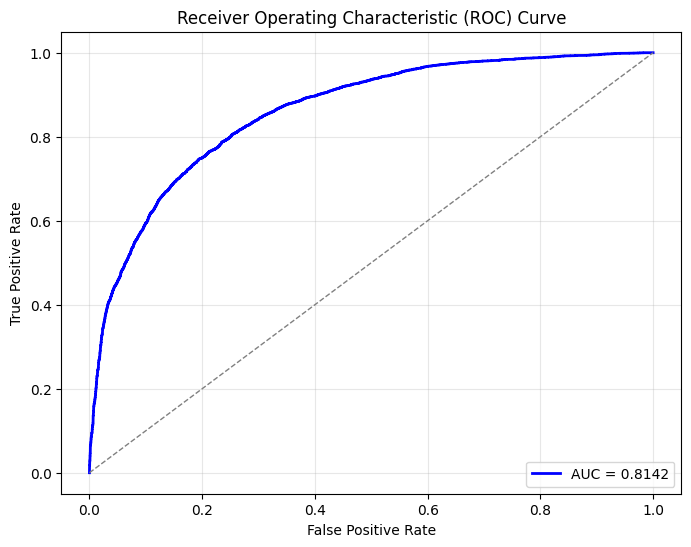

In [50]:
plot_auc(fpr, tpr, test_auc)

In [60]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


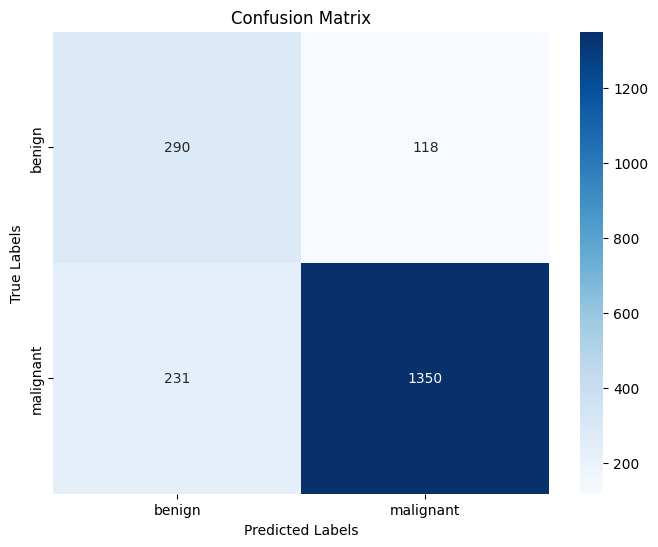

In [58]:
plot_confusion_matrix(cm, class_names=['benign', 'malignant'])

resnet18

In [25]:
import torch.nn as nn
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
num_classes=2
log_interval = 10
l2_decay = 0.01
model = Resnet18(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [26]:
import os
from IPython.display import FileLink

# Model training
model.to(device)  

best_accuracy = 0
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'resnet18'

# Set Kaggle working directory
os.chdir(r'/kaggle/working')

for epoch in range(1, total_epochs + 1):
    # Training step
    train(epoch, model, total_epochs, train_loader, criterion, l2_decay)

    # Validation step
    with torch.no_grad():
        test_loss, accuracy, cm, auc = validation(model, val_loader)

    # Handle model state for single/multiple GPUs
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Save directory for models
    model_save_dir = os.path.join('model', project_name, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping check
    early_stop(test_loss, model)

    # Save the best model based on AUC
    if auc > best_accuracy:
        best_accuracy = auc
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model_state_dict, model_save_path, _use_new_zipfile_serialization=False)
        print(f"Model saved at: {os.path.abspath(model_save_path)}")

        # Generate download link for Kaggle
        print("Generating download link for the saved model...")
        display(FileLink(model_save_path))

    # Stop training if early stopping is triggered
    if early_stop.early_stop:
        print("Early stopping")
        break

# Save the model at the final epoch if early stopping is triggered
final_model_save_path = os.path.join(model_save_dir, f'{model_name}_final_epoch.pth')
torch.save(model_state_dict, final_model_save_path, _use_new_zipfile_serialization=False)
print(f"Final model saved at: {os.path.abspath(final_model_save_path)}")

# Generate download link for the final model
print("Generating download link for the final model...")
display(FileLink(final_model_save_path))


Epoch 2/50: 100%|██████████| 639/639 [02:55<00:00,  3.63batch/s]


train accuracy: 79.9549789428711%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9231

Test set: Average loss: 0.3766, Accuracy: 84.41%

Validation loss decreased (inf --> 0.376577). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_1.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_1.pth

Epoch 3/50: 100%|██████████| 639/639 [01:30<00:00,  7.03batch/s]


train accuracy: 84.26152801513672%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8929

Test set: Average loss: 0.3991, Accuracy: 77.48%

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 639/639 [01:30<00:00,  7.03batch/s]


train accuracy: 84.1391830444336%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9215

Test set: Average loss: 0.3611, Accuracy: 81.80%

Validation loss decreased (0.376577 --> 0.361149). Saving model...


Epoch 5/50: 100%|██████████| 639/639 [01:29<00:00,  7.10batch/s]


train accuracy: 83.75257110595703%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9082

Test set: Average loss: 0.3867, Accuracy: 80.39%

EarlyStopping counter: 1 out of 20


Epoch 6/50: 100%|██████████| 639/639 [01:30<00:00,  7.03batch/s]


train accuracy: 83.78682708740234%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8896

Test set: Average loss: 0.4050, Accuracy: 77.43%

EarlyStopping counter: 2 out of 20


Epoch 7/50: 100%|██████████| 639/639 [01:27<00:00,  7.29batch/s]


train accuracy: 83.89449310302734%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9115

Test set: Average loss: 0.3686, Accuracy: 80.34%

EarlyStopping counter: 3 out of 20


Epoch 8/50: 100%|██████████| 639/639 [01:31<00:00,  6.98batch/s]


train accuracy: 83.51766967773438%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9307

Test set: Average loss: 0.3359, Accuracy: 81.95%

Validation loss decreased (0.361149 --> 0.335918). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_7.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_7.pth

Epoch 9/50: 100%|██████████| 639/639 [01:28<00:00,  7.20batch/s]


train accuracy: 84.45238494873047%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9121

Test set: Average loss: 0.3846, Accuracy: 81.10%

EarlyStopping counter: 1 out of 20


Epoch 10/50: 100%|██████████| 639/639 [01:27<00:00,  7.27batch/s]


train accuracy: 84.21748352050781%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9316

Test set: Average loss: 0.3318, Accuracy: 83.76%

Validation loss decreased (0.335918 --> 0.331786). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_9.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_9.pth

Epoch 11/50: 100%|██████████| 639/639 [01:30<00:00,  7.05batch/s]


train accuracy: 89.7279052734375%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9478

Test set: Average loss: 0.2875, Accuracy: 85.62%

Validation loss decreased (0.331786 --> 0.287488). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_10.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_10.pth

Epoch 12/50: 100%|██████████| 639/639 [01:28<00:00,  7.26batch/s]


train accuracy: 91.57286834716797%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9422

Test set: Average loss: 0.3038, Accuracy: 84.77%

EarlyStopping counter: 1 out of 20


Epoch 13/50: 100%|██████████| 639/639 [01:28<00:00,  7.26batch/s]


train accuracy: 92.23353576660156%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9484

Test set: Average loss: 0.2912, Accuracy: 84.92%

EarlyStopping counter: 2 out of 20
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_12.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_12.pth

Epoch 14/50: 100%|██████████| 639/639 [01:28<00:00,  7.22batch/s]


train accuracy: 92.7278060913086%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9228

Test set: Average loss: 0.3824, Accuracy: 83.86%

EarlyStopping counter: 3 out of 20


Epoch 15/50: 100%|██████████| 639/639 [01:26<00:00,  7.40batch/s]


train accuracy: 93.34931945800781%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9383

Test set: Average loss: 0.3347, Accuracy: 83.26%

EarlyStopping counter: 4 out of 20


Epoch 16/50: 100%|██████████| 639/639 [01:26<00:00,  7.37batch/s]


train accuracy: 93.44719696044922%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9188

Test set: Average loss: 0.3834, Accuracy: 82.60%

EarlyStopping counter: 5 out of 20


Epoch 17/50: 100%|██████████| 639/639 [01:27<00:00,  7.31batch/s]


train accuracy: 93.93167877197266%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9248

Test set: Average loss: 0.3713, Accuracy: 83.31%

EarlyStopping counter: 6 out of 20


Epoch 18/50: 100%|██████████| 639/639 [01:27<00:00,  7.32batch/s]


train accuracy: 94.22041320800781%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9352

Test set: Average loss: 0.3422, Accuracy: 83.91%

EarlyStopping counter: 7 out of 20


Epoch 19/50: 100%|██████████| 639/639 [01:26<00:00,  7.41batch/s]


train accuracy: 94.03445434570312%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9030

Test set: Average loss: 0.4073, Accuracy: 81.70%

EarlyStopping counter: 8 out of 20


Epoch 20/50: 100%|██████████| 639/639 [01:28<00:00,  7.20batch/s]


train accuracy: 94.08338928222656%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9018

Test set: Average loss: 0.4341, Accuracy: 80.54%

EarlyStopping counter: 9 out of 20


Epoch 21/50: 100%|██████████| 639/639 [01:29<00:00,  7.18batch/s]


train accuracy: 96.33454132080078%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9358

Test set: Average loss: 0.3564, Accuracy: 84.26%

EarlyStopping counter: 10 out of 20


Epoch 22/50: 100%|██████████| 639/639 [01:28<00:00,  7.25batch/s]


train accuracy: 96.75540924072266%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9265

Test set: Average loss: 0.3840, Accuracy: 83.36%

EarlyStopping counter: 11 out of 20


Epoch 23/50: 100%|██████████| 639/639 [01:27<00:00,  7.26batch/s]


train accuracy: 97.29862213134766%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9233

Test set: Average loss: 0.4058, Accuracy: 83.21%

EarlyStopping counter: 12 out of 20


Epoch 24/50: 100%|██████████| 639/639 [01:29<00:00,  7.15batch/s]


train accuracy: 97.20563507080078%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9264

Test set: Average loss: 0.3920, Accuracy: 83.61%

EarlyStopping counter: 13 out of 20


Epoch 25/50: 100%|██████████| 639/639 [01:28<00:00,  7.25batch/s]


train accuracy: 97.25946807861328%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9359

Test set: Average loss: 0.3703, Accuracy: 84.51%

EarlyStopping counter: 14 out of 20


Epoch 26/50: 100%|██████████| 639/639 [01:26<00:00,  7.39batch/s]


train accuracy: 97.50415802001953%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9280

Test set: Average loss: 0.4009, Accuracy: 84.01%

EarlyStopping counter: 15 out of 20


Epoch 27/50: 100%|██████████| 639/639 [01:29<00:00,  7.17batch/s]


train accuracy: 97.41606903076172%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9254

Test set: Average loss: 0.4030, Accuracy: 83.51%

EarlyStopping counter: 16 out of 20


Epoch 28/50: 100%|██████████| 639/639 [01:27<00:00,  7.33batch/s]


train accuracy: 97.47480010986328%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9291

Test set: Average loss: 0.4006, Accuracy: 83.26%

EarlyStopping counter: 17 out of 20


Epoch 29/50: 100%|██████████| 639/639 [01:27<00:00,  7.32batch/s]


train accuracy: 97.77821350097656%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9236

Test set: Average loss: 0.4072, Accuracy: 83.46%

EarlyStopping counter: 18 out of 20


Epoch 30/50: 100%|██████████| 639/639 [01:25<00:00,  7.45batch/s]


train accuracy: 97.75863647460938%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9325

Test set: Average loss: 0.3908, Accuracy: 83.96%

EarlyStopping counter: 19 out of 20


Epoch 31/50: 100%|██████████| 639/639 [01:27<00:00,  7.30batch/s]


train accuracy: 98.16482543945312%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9321

Test set: Average loss: 0.3899, Accuracy: 84.21%

EarlyStopping counter: 20 out of 20
Early stopping
Final model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_final_epoch.pth
Generating download link for the final model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_final_epoch.pth

In [27]:
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve

import torch

import numpy as np

import torch.nn.functional as F



def test(model, test_loader):
    name = 'test'
    len_test_loader = len(test_loader.dataset)
    model.eval()

    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    true_labels = []  # Collect true labels here
    class_names = ['benign', 'malignant']

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect predictions
        true_labels.extend(target.cpu().numpy())  # Collect true labels

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Ensure all_predictions and true_labels are flattened
    all_predictions = np.array(all_predictions)
    true_labels = np.array(true_labels)

    # Classification metrics -> accuracy, F1 score
    print(metrics.classification_report(true_labels, all_predictions, target_names=class_names, digits=4))

    # Confusion matrix
    cm = metrics.confusion_matrix(true_labels, all_predictions)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve and AUC
    num_classes = len(class_names)
    label_onehot = np.eye(num_classes)[true_labels.astype(int)]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    # Specificity, Sensitivity, AUC
    test_loss /= len_test_loader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len_test_loader, 100. * correct / len_test_loader))

    #return 100. * correct / len_test_loader, test_loss, auc_value
    return 100. * correct / len_test_loader, test_loss, auc_value, fpr, tpr



In [29]:
test_accuracy, test_loss, test_auc, fpr, tpr = test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.6733    0.4680    0.5522      1938
   malignant     0.8127    0.9104    0.8588      4913

    accuracy                         0.7853      6851
   macro avg     0.7430    0.6892    0.7055      6851
weighted avg     0.7733    0.7853    0.7721      6851


Confusion Matrix:
 [[ 907 1031]
 [ 440 4473]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8155

test set: Average loss: 0.6096, Accuracy: 5380/6851 (78.53%)



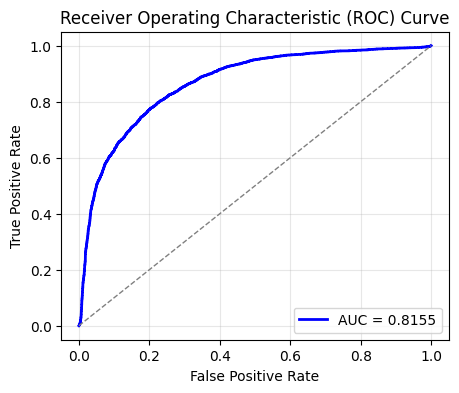

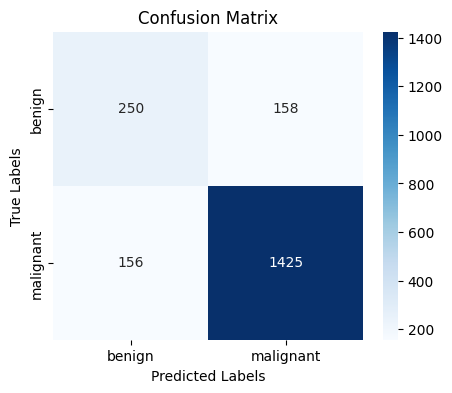

In [32]:
import matplotlib.pyplot as plt

def plot_auc(fpr, tpr, auc_value):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()   
plot_auc(fpr, tpr, test_auc)

import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(cm, class_names=['benign', 'malignant'])    

resnet 50

In [33]:
import torch
import torchvision.models as models

# For ResNet18
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()  # Set the model to evaluation mode
print("ResNet50 Model:")
print(resnet50)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


ResNet50 Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1,

In [15]:
import torch

import torch.nn as nn

import torchvision.models as models

In [16]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.features = model_resnet50.fc.in_features
        self.fc = nn.Linear(self.features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [17]:
model = Resnet50()

print(model)

Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

next run 
1 early stop
2 train fun
3 val fun

In [43]:
import torch.nn as nn
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
num_classes=2
log_interval = 10
l2_decay = 0.01
#model = customVGG16(num_classes=num_classes)
model = Resnet50(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [45]:
import os
from IPython.display import FileLink

# Model training
model.to(device)  

best_accuracy = 0
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification_3'
model_name = 'resnet18'

# Set Kaggle working directory
os.chdir(r'/kaggle/working')

for epoch in range(1, total_epochs + 1):
    # Training step
    train(epoch, model, total_epochs, train_loader, criterion, l2_decay)

    # Validation step
    with torch.no_grad():
        test_loss, accuracy, cm, auc = validation(model, val_loader)

    # Handle model state for single/multiple GPUs
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Save directory for models
    model_save_dir = os.path.join('model', project_name, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping check
    early_stop(test_loss, model)

    # Save the best model based on AUC
    if auc > best_accuracy:
        best_accuracy = auc
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model_state_dict, model_save_path, _use_new_zipfile_serialization=False)
        print(f"Model saved at: {os.path.abspath(model_save_path)}")

        # Generate download link for Kaggle
        print("Generating download link for the saved model...")
        display(FileLink(model_save_path))

    # Stop training if early stopping is triggered
    if early_stop.early_stop:
        print("Early stopping")
        break

# Save the model at the final epoch if early stopping is triggered
final_model_save_path = os.path.join(model_save_dir, f'{model_name}_final_epoch.pth')
torch.save(model_state_dict, final_model_save_path, _use_new_zipfile_serialization=False)
print(f"Final model saved at: {os.path.abspath(final_model_save_path)}")

# Generate download link for the final model
print("Generating download link for the final model...")
display(FileLink(final_model_save_path))


Epoch 2/50: 100%|██████████| 639/639 [02:45<00:00,  3.86batch/s]


train accuracy: 84.15875244140625%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9070

Test set: Average loss: 0.3947, Accuracy: 80.69%

Validation loss decreased (inf --> 0.394678). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_1.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_1.pth

Epoch 3/50: 100%|██████████| 639/639 [02:41<00:00,  3.96batch/s]


train accuracy: 81.64334106445312%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9213

Test set: Average loss: 0.3436, Accuracy: 81.45%

Validation loss decreased (0.394678 --> 0.343557). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_2.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_2.pth

Epoch 4/50: 100%|██████████| 639/639 [02:41<00:00,  3.96batch/s]


train accuracy: 81.20289611816406%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8504

Test set: Average loss: 0.4715, Accuracy: 75.06%

EarlyStopping counter: 1 out of 20


Epoch 5/50: 100%|██████████| 639/639 [02:41<00:00,  3.95batch/s]


train accuracy: 80.62542724609375%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8475

Test set: Average loss: 0.4741, Accuracy: 75.82%

EarlyStopping counter: 2 out of 20


Epoch 7/50:  87%|████████▋ | 558/639 [02:21<00:21,  3.74batch/s]

Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8360

Test set: Average loss: 0.5241, Accuracy: 72.90%

EarlyStopping counter: 4 out of 20


Epoch 8/50:  87%|████████▋ | 553/639 [02:19<00:21,  4.00batch/s]

Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9039

Test set: Average loss: 0.4142, Accuracy: 82.00%

EarlyStopping counter: 5 out of 20


Epoch 9/50: 100%|██████████| 639/639 [02:41<00:00,  3.95batch/s]


train accuracy: 80.9337387084961%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.7546

Test set: Average loss: 0.5793, Accuracy: 65.06%

EarlyStopping counter: 6 out of 20


Epoch 10/50: 100%|██████████| 639/639 [02:41<00:00,  3.96batch/s]


train accuracy: 80.60095977783203%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8442

Test set: Average loss: 0.4863, Accuracy: 74.86%

EarlyStopping counter: 7 out of 20


Epoch 11/50: 100%|██████████| 639/639 [02:41<00:00,  3.97batch/s]


train accuracy: 84.59430694580078%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9230

Test set: Average loss: 0.3549, Accuracy: 82.35%

EarlyStopping counter: 8 out of 20
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_10.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_10.pth

Epoch 12/50: 100%|██████████| 639/639 [02:42<00:00,  3.93batch/s]


train accuracy: 86.85523986816406%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9318

Test set: Average loss: 0.3324, Accuracy: 84.51%

Validation loss decreased (0.343557 --> 0.332404). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_11.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_11.pth

Epoch 13/50: 100%|██████████| 639/639 [02:42<00:00,  3.93batch/s]


train accuracy: 86.88949584960938%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9370

Test set: Average loss: 0.3174, Accuracy: 84.77%

Validation loss decreased (0.332404 --> 0.317350). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_12.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_12.pth

Epoch 14/50: 100%|██████████| 639/639 [02:42<00:00,  3.94batch/s]


train accuracy: 87.5550537109375%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9261

Test set: Average loss: 0.3463, Accuracy: 83.41%

EarlyStopping counter: 1 out of 20


Epoch 15/50: 100%|██████████| 639/639 [02:41<00:00,  3.95batch/s]


train accuracy: 87.95145416259766%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9377

Test set: Average loss: 0.3302, Accuracy: 85.97%

EarlyStopping counter: 2 out of 20
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_14.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_14.pth

Epoch 16/50: 100%|██████████| 639/639 [02:41<00:00,  3.97batch/s]


train accuracy: 87.52569580078125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9367

Test set: Average loss: 0.3167, Accuracy: 85.12%

Validation loss decreased (0.317350 --> 0.316667). Saving model...


Epoch 17/50: 100%|██████████| 639/639 [02:42<00:00,  3.94batch/s]


train accuracy: 88.33316802978516%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9332

Test set: Average loss: 0.3271, Accuracy: 84.51%

EarlyStopping counter: 1 out of 20


Epoch 18/50: 100%|██████████| 639/639 [02:40<00:00,  3.99batch/s]


train accuracy: 88.70020294189453%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9367

Test set: Average loss: 0.3209, Accuracy: 84.46%

EarlyStopping counter: 2 out of 20


Epoch 19/50: 100%|██████████| 639/639 [02:42<00:00,  3.93batch/s]


train accuracy: 88.95468139648438%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8997

Test set: Average loss: 0.4003, Accuracy: 78.88%

EarlyStopping counter: 3 out of 20


Epoch 20/50: 100%|██████████| 639/639 [02:41<00:00,  3.96batch/s]


train accuracy: 88.61701202392578%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8945

Test set: Average loss: 0.4108, Accuracy: 80.74%

EarlyStopping counter: 4 out of 20


Epoch 21/50: 100%|██████████| 639/639 [02:40<00:00,  3.98batch/s]


train accuracy: 91.16178894042969%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9342

Test set: Average loss: 0.3263, Accuracy: 85.22%

EarlyStopping counter: 5 out of 20


Epoch 22/50: 100%|██████████| 639/639 [02:40<00:00,  3.97batch/s]


train accuracy: 91.98884582519531%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9308

Test set: Average loss: 0.3371, Accuracy: 84.16%

EarlyStopping counter: 6 out of 20


Epoch 23/50: 100%|██████████| 639/639 [02:42<00:00,  3.94batch/s]


train accuracy: 91.98884582519531%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9355

Test set: Average loss: 0.3261, Accuracy: 85.17%

EarlyStopping counter: 7 out of 20


Epoch 24/50: 100%|██████████| 639/639 [02:42<00:00,  3.93batch/s]


train accuracy: 92.33140563964844%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9290

Test set: Average loss: 0.3430, Accuracy: 84.87%

EarlyStopping counter: 8 out of 20


Epoch 25/50: 100%|██████████| 639/639 [02:42<00:00,  3.94batch/s]


train accuracy: 92.282470703125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9298

Test set: Average loss: 0.3403, Accuracy: 84.36%

EarlyStopping counter: 9 out of 20


Epoch 26/50: 100%|██████████| 639/639 [02:41<00:00,  3.94batch/s]


train accuracy: 92.76696014404297%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9283

Test set: Average loss: 0.3535, Accuracy: 84.46%

EarlyStopping counter: 10 out of 20


Epoch 27/50: 100%|██████████| 639/639 [02:40<00:00,  3.98batch/s]


train accuracy: 93.00675201416016%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9161

Test set: Average loss: 0.3804, Accuracy: 83.46%

EarlyStopping counter: 11 out of 20


Epoch 28/50: 100%|██████████| 639/639 [02:42<00:00,  3.94batch/s]


train accuracy: 92.7620620727539%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9177

Test set: Average loss: 0.3774, Accuracy: 83.71%

EarlyStopping counter: 12 out of 20


Epoch 29/50: 100%|██████████| 639/639 [02:38<00:00,  4.03batch/s]


train accuracy: 92.90887451171875%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9216

Test set: Average loss: 0.3725, Accuracy: 83.46%

EarlyStopping counter: 13 out of 20


Epoch 30/50: 100%|██████████| 639/639 [02:39<00:00,  4.00batch/s]


train accuracy: 93.46187591552734%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9264

Test set: Average loss: 0.3604, Accuracy: 83.76%

EarlyStopping counter: 14 out of 20


Epoch 31/50: 100%|██████████| 639/639 [02:39<00:00,  4.00batch/s]


train accuracy: 93.44719696044922%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9210

Test set: Average loss: 0.3778, Accuracy: 84.11%

EarlyStopping counter: 15 out of 20


Epoch 32/50: 100%|██████████| 639/639 [02:38<00:00,  4.02batch/s]


train accuracy: 93.51081848144531%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9304

Test set: Average loss: 0.3556, Accuracy: 84.51%

EarlyStopping counter: 16 out of 20


Epoch 33/50: 100%|██████████| 639/639 [02:39<00:00,  4.02batch/s]


train accuracy: 93.72125244140625%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9258

Test set: Average loss: 0.3639, Accuracy: 84.62%

EarlyStopping counter: 17 out of 20


Epoch 34/50: 100%|██████████| 639/639 [02:40<00:00,  3.98batch/s]


train accuracy: 93.75550842285156%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9189

Test set: Average loss: 0.3818, Accuracy: 84.11%

EarlyStopping counter: 18 out of 20


Epoch 35/50: 100%|██████████| 639/639 [02:40<00:00,  3.97batch/s]


train accuracy: 93.75550842285156%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9260

Test set: Average loss: 0.3608, Accuracy: 84.92%

EarlyStopping counter: 19 out of 20


Epoch 36/50: 100%|██████████| 639/639 [02:40<00:00,  3.97batch/s]


train accuracy: 93.6869888305664%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9235

Test set: Average loss: 0.3713, Accuracy: 84.87%

EarlyStopping counter: 20 out of 20
Early stopping
Final model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_final_epoch.pth
Generating download link for the final model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_final_epoch.pth

In [46]:
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve

import torch

import numpy as np

import torch.nn.functional as F



def test(model, test_loader):
    name = 'test'
    len_test_loader = len(test_loader.dataset)
    model.eval()

    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    true_labels = []  # Collect true labels here
    class_names = ['benign', 'malignant']

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect predictions
        true_labels.extend(target.cpu().numpy())  # Collect true labels

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Ensure all_predictions and true_labels are flattened
    all_predictions = np.array(all_predictions)
    true_labels = np.array(true_labels)

    # Classification metrics -> accuracy, F1 score
    print(metrics.classification_report(true_labels, all_predictions, target_names=class_names, digits=4))

    # Confusion matrix
    cm = metrics.confusion_matrix(true_labels, all_predictions)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve and AUC
    num_classes = len(class_names)
    label_onehot = np.eye(num_classes)[true_labels.astype(int)]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    # Specificity, Sensitivity, AUC
    test_loss /= len_test_loader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len_test_loader, 100. * correct / len_test_loader))

    #return 100. * correct / len_test_loader, test_loss, auc_value
    return 100. * correct / len_test_loader, test_loss, auc_value, fpr, tpr



In [47]:
test_accuracy, test_loss, test_auc, fpr, tpr = test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.5913    0.4912    0.5366      1938
   malignant     0.8119    0.8661    0.8381      4913

    accuracy                         0.7600      6851
   macro avg     0.7016    0.6786    0.6874      6851
weighted avg     0.7495    0.7600    0.7528      6851


Confusion Matrix:
 [[ 952  986]
 [ 658 4255]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.7912

test set: Average loss: 0.6254, Accuracy: 5207/6851 (76.00%)



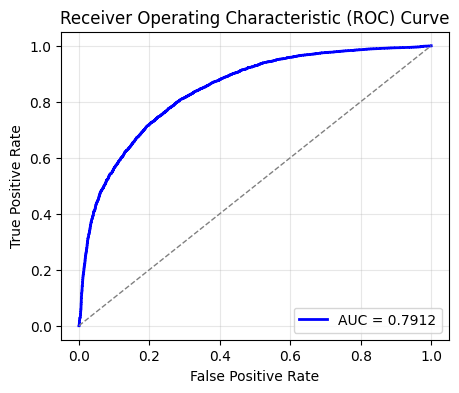

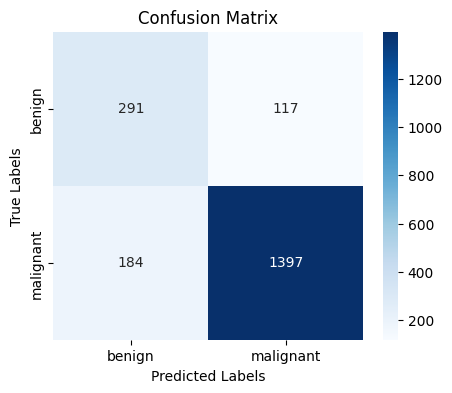

In [48]:
import matplotlib.pyplot as plt

def plot_auc(fpr, tpr, auc_value):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()   
plot_auc(fpr, tpr, test_auc)

import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(cm, class_names=['benign', 'malignant'])    